# Cross-validation of prediction accuracy

## Environment settings
```sh
# Working Directory
cd Bac2fFeature/scripts/03_cross_validation
# Conda environment
conda activate bac2feature_experiment
# Output Directory
directories=(
    "../../data/cross_validation"
)
for dir in "${directories[@]}"; do
  if [ ! -d "$dir" ]; then
    mkdir -p "$dir"
  fi
done
```

In [1]:
import json
import os
import random

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import wilcoxon, friedmanchisquare
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import f1_score, precision_score, recall_score
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.sans-serif'] = ["Arial", "DejaVu Sans", "Lucida Grande", "Verdana"]
matplotlib.rcParams["figure.figsize"] = [4, 3]
matplotlib.rcParams["font.size"] = 10
matplotlib.rcParams["axes.labelcolor"] = "#000000"
matplotlib.rcParams["axes.linewidth"] = 1.0
matplotlib.rcParams["xtick.major.width"] = 1.0
matplotlib.rcParams["ytick.major.width"] = 1.0

cmap1 = plt.cm.tab20
cmap2 = plt.cm.Set3

In [2]:
# Continuous traits
nt = ['cell_diameter', 'cell_length', 'doubling_h', 'growth_tmp', 'optimum_tmp', 'optimum_ph', 'genome_size', 'gc_content', 'coding_genes', 'rRNA16S_genes', 'tRNA_genes']
# Categorical traits
ct = ['gram_stain',
      'sporulation', 'motility', 'range_salinity', 'facultative_respiration',
      'anaerobic_respiration', 'aerobic_respiration', 'mesophilic_range_tmp',
      'thermophilic_range_tmp', 'psychrophilic_range_tmp',
      'bacillus_cell_shape', 'coccus_cell_shape', 'filament_cell_shape',
      'coccobacillus_cell_shape', 'vibrio_cell_shape', 'spiral_cell_shape']
# Visualization titles of traits
titles = {'cell_diameter': 'Cell diameter', 'cell_length': 'Cell length', 'doubling_h': 'Doubling time', 'growth_tmp': 'Growth temp.', 'optimum_tmp': 'Optimum temp.', 'optimum_ph': 'Optimum pH', 'genome_size': 'Genome size', 'gc_content': 'GC content', 'coding_genes': 'Coding genes', 'rRNA16S_genes': 'rRNA16S genes', 'tRNA_genes': 'tRNA genes', 'gram_stain': 'Gram stain', 'sporulation': 'Sporulation', 'motility': 'Motility', 'range_salinity': 'Halophile', 'facultative_respiration': 'Facultative', 'anaerobic_respiration': 'Anaerobe', 'aerobic_respiration':'Aerobe' ,'mesophilic_range_tmp': 'Mesophile', 'thermophilic_range_tmp':'Thermophile', 'psychrophilic_range_tmp': 'Psychrophile', 'bacillus_cell_shape': 'Bacillus', 'coccus_cell_shape': 'Coccus', 'filament_cell_shape': 'Filament', 'coccobacillus_cell_shape': 'Coccobacillus', 'vibrio_cell_shape': 'Vibrio', 'spiral_cell_shape': 'Spiral'}

## Constructing cross-validation dataset

### Split 16S rRNA gene sequences and trait data
```sh
# Extract header ID of 16S rRNA sequences
seqkit seq -n ../../data/intermediate_dir/silva_msa_trim.fasta > ../../data/cross_validation/header.txt
```

In [3]:
# Split the dataset for 10-fold cross validation
random.seed(0)
out_dir = '../../data/cross_validation'
## Use header for sequences' ID
header = pd.read_csv("../../data/cross_validation/header.txt", names=["header"], dtype=str)
l_header = list(header["header"].values)
l_header_shuffled = random.sample(l_header, len(l_header))
## Split
trait_table = pd.read_csv("../../data/ref_bac2feature/trait_bac2feature.tsv", sep="\t", dtype=str)
for i, test_header in enumerate(np.array_split(l_header_shuffled, 10)):
    # Path
    split_dir = os.path.join(out_dir, f"split_{i}")
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)
    test_header_path = os.path.join(split_dir, "nodeid_test.txt")
    ref_header_path = os.path.join(split_dir, "nodeid_ref.txt")
    ref_trait_path = os.path.join(split_dir, "traits.tsv")
    # Split header
    set_test_header = set(test_header)
    ref_header = [h for h in l_header if h not in set_test_header]
    with open(test_header_path, 'w') as f:
        f.write('\n'.join(test_header))
    with open(ref_header_path, 'w') as f:
        f.write('\n'.join(ref_header))
    # Split trait table
    is_ref = trait_table["species_tax_id"].apply(
                 lambda x: x not in set_test_header)
    trait_table[is_ref].to_csv(ref_trait_path, sep="\t", index=False)

```sh
# Split full 16S rRNA sequences into test and reference data
for i in $(seq 0 9); do seqkit grep -nf ../../data/cross_validation/split_$i/nodeid_test.txt ../../data/intermediate_dir/SILVA_138.1_SSURef_NR99_tax_silva_taxid.fasta > ../../data/cross_validation/split_$i/test_seq_full.fasta; done
for i in $(seq 0 9); do seqkit grep -nf ../../data/cross_validation/split_$i/nodeid_ref.txt ../../data/intermediate_dir/SILVA_138.1_SSURef_NR99_tax_silva_taxid.fasta > ../../data/cross_validation/split_$i/ref_seq_full.fasta; done
```

### Constructing reference dataset

#### Homology-based prediction
```sh
for i in $(seq 0 9); do makeblastdb -in ../../data/cross_validation/split_$i/ref_seq_full.fasta -out ../../data/cross_validation/split_$i/blastdb/ref_seq_full -dbtype nucl; done
```

#### Taxonomy-based prediction

In [ ]:
# Trait table
trait_path = "../../data/ref_bac2feature/trait_bac2feature.tsv"
trait = pd.read_csv(trait_path, sep="\t", dtype=str)
# SILVA taxonomy
silva_metadata_path = "../../data/intermediate_dir/silva_taxonomy.tsv"
silva_metadata = pd.read_csv(silva_metadata_path, sep="\t", dtype=str)
silva_metadata.fillna("", inplace=True)
silva_metadata["taxonomy"] = ("k__" + silva_metadata["superkingdom"] +
                              "; p__" + silva_metadata["phylum"] +
                              "; c__" + silva_metadata["class"] +
                              "; o__" + silva_metadata["order"] +
                              "; f__" + silva_metadata["family"] +
                              "; g__" + silva_metadata["genus"] +
                              "; s__" + silva_metadata["species"])
tax_cols = ['taxonomy', 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
# Merge
trait = pd.merge(trait, silva_metadata[["species_tax_id"]+tax_cols], how="inner", on="species_tax_id")

# Split
out_dir = '../../data/cross_validation'
for i in range(10):
    ## Path
    split_dir = os.path.join(out_dir, f"split_{i}")
    ## ID of Reference seqs
    ref_header_path = os.path.join(split_dir, "nodeid_ref.txt")
    ref_header = []
    with open(ref_header_path) as f:
        for l in f.readlines():
            ref_header.append(l.split()[0])
    set_ref_header = set(ref_header)
    ## Split the trait table
    ref_trait_path = os.path.join(split_dir, "traits_with_taxonomy.tsv")
    is_ref = trait["species_tax_id"].apply(
                 lambda x: x in ref_header)
    trait[is_ref].to_csv(ref_trait_path, sep="\t", index=False)
    # Taxonomy of reference seqs
    ref_taxonomy_path = os.path.join(split_dir, "ref_taxonomy.tsv")
    trait[is_ref][["species_tax_id", "taxonomy"]].to_csv(ref_taxonomy_path, sep="\t", index=False, header=False)

clades = ["superkingdom", "phylum", "class",
          "order", "family", "genus", "species"]
# Make reference dataset for taxonomy-based prediction
for i in range(10):
    split_dir = os.path.join(out_dir, f"split_{i}")
    ref_trait_path = os.path.join(split_dir, "traits_with_taxonomy.tsv")
    ref_trait = pd.read_csv(ref_trait_path, sep="\t")

    # Calculate empirical distributions of reference traits
    emp_trait = {}
    for t in nt+ct:
        emp = {}
        ref_trait[t] = ref_trait[t].astype(float)
        for c in clades:
            cols = [c, t]
            groupby = ref_trait[cols].groupby(c).mean()
            groupby = groupby.reset_index()
            groupby.fillna({t: "NA"}, inplace=True)
            emp[c] = {groupby.loc[i, c]: groupby.loc[i, t]
                        for i in range(groupby.shape[0])}
        emp_trait[t] = emp
    # Save
    emp_file = open(os.path.join(split_dir, 'empirical_dict.json'), mode='w')
    json.dump(emp_trait, emp_file, ensure_ascii=False)
    emp_file.close()

```sh
for i in $(seq 0 9); do qiime tools import --type 'FeatureData[Taxonomy]' --input-format HeaderlessTSVTaxonomyFormat --input-path ../../data/cross_validation/split_$i/ref_taxonomy.tsv --output-path ../../data/cross_validation/split_$i/ref_taxonomy.qza; done
for i in $(seq 0 9); do qiime tools import --type 'FeatureData[Sequence]' --input-path ../../data/cross_validation/split_$i/ref_seq_full.fasta --output-path ../../data/cross_validation/split_$i/ref_seq_full.qza; done
for i in $(seq 0 9); do qiime tools import --type 'FeatureData[Sequence]' --input-path ../../data/cross_validation/split_$i/test_seq_full.fasta --output-path ../../data/cross_validation/split_$i/test_seq_full.qza; done
# Training naive bayes classifier
for i in $(seq 0 9); do qiime feature-classifier fit-classifier-naive-bayes --i-reference-reads ../../data/cross_validation/split_$i/ref_seq_full.qza --i-reference-taxonomy ../../data/cross_validation/split_$i/ref_taxonomy.qza --o-classifier ../../data/cross_validation/split_$i/classifier.qza; done
```

#### Phylogeny-based prediction
```sh
for i in $(seq 0 9); do ./make_pro_ref.sh -t ../../data/ref_bac2feature/phylogeny/phylogeny.tre -a ../../data/ref_bac2feature/phylogeny/phylogeny.fasta -n ../../data/cross_validation/split_$i/nodeid_ref.txt -o ../../data/cross_validation/split_$i; done
```

## Cross-validation

```sh
# Homology-based prediction
for i in $(seq 0 9); do bac_to_feature.py -s ../../data/cross_validation/split_$i/test_seq_full.fasta -o ../../data/cross_validation/split_$i/estimation_blast.tsv -m homology --ref_blastdb ../../data/cross_validation/split_$i/blastdb/ref_seq_full --ref_table ../../data/cross_validation/split_$i/traits.tsv --threads 1; done

# Taxonomy-based prediction
for i in $(seq 0 9); do bac_to_feature.py -s ../../data/cross_validation/split_$i/test_seq_full.fasta -o ../../data/cross_validation/split_$i/estimation_blast.tsv -m taxonomy --ref_nb_classifier ../../data/cross_validation/split_$i/classifier.qza --ref_trait_taxonomy ../../data/cross_validation/split_$i/traits.tsv --threads 1; done

# Phylogeny-based prediction
for i in $(seq 0 9); do bac_to_feature.py -s ../../data/cross_validation/split_$i/test_seq_full.fasta -o ../../data/cross_validation/split_$i/estimation_full.tsv -m phylogeny --ref_dir ../../data/cross_validation/split_$i --ref_table ../../data/cross_validation/split_$i/traits.tsv --threads 1 --calculate_NSTI; done
```

```sh
# Concatenate the prediction results
head -n 1 ../../data/cross_validation/split_0/estimation_full.tsv > ../../data/cross_validation/estimation_picrust.tsv && ls ../../data/cross_validation/split_*/estimation_full.tsv | xargs -n 1 tail -n +2 >> ../../data/cross_validation/estimation_picrust.tsv

head -n 1 ../../data/cross_validtion/split_0/estimation_blast.tsv > ../../data/cross_validation/estimation_blast.tsv && ls ../../data/cross_validation/split_*/estimation_blast.tsv | xargs -n 1 tail -n +2 >> ../../data/cross_validation/estimation_blast.tsv

head -n 1 ../../data/cross_validation/split_0/estimation_naive.tsv > ../../data/cross_validation/estimation_naive.tsv && ls ../../data/cross_validation/split_*/estimation_naive.tsv | xargs -n 1 tail -n +2 >> ../../data/cross_validation/estimation_naive.tsv
```

## Calculating prediction accuracy

In [4]:
# Functions
def get_pred_and_true_df(pred_vals_path, true_vals_path):
    # Prediction
    pred_vals = pd.read_csv(pred_vals_path, sep="\t")
    pred_vals["sequence"] = pred_vals["sequence"].astype(str)
    # Reference
    true_vals = pd.read_csv(true_vals_path, sep="\t", dtype=str)
    cmp = pd.merge(pred_vals, true_vals,
                   left_on='sequence', right_on="species_tax_id", how='inner', suffixes=['_e', '_t'])
    return cmp

def remove_null_values(cmp, t, dtype):
    known_flag = (~cmp[t+'_t'].isnull()) & (~cmp[t+'_e'].isnull())
    pred_vals, true_vals = cmp[known_flag][t+'_e'], cmp[known_flag][t+'_t']
    if dtype == 'float':
        pred_vals = pred_vals.astype(float)
        true_vals = true_vals.astype(float)
    elif dtype == 'int':
        pred_vals = pred_vals.astype(int)
        true_vals = true_vals.astype(int)
    return pred_vals, true_vals

### Continuous traits

In [5]:
true_vals_path = "../../data/ref_bac2feature/trait_bac2feature.tsv"
true_vals = pd.read_csv(true_vals_path, sep="\t", dtype=str)

# Continuous traits
for i in range(0, 10):
    # Homology
    homology_result_path = f"../../data/cross_validation/split_{i}/estimation_blast.tsv"
    cmp = get_pred_and_true_df(pred_vals_path=homology_result_path, true_vals_path=true_vals_path)
    res_list_homology = []
    for t in nt:
        pred_vals, true_vals = remove_null_values(cmp=cmp, t=t, dtype='float')
        res_list_homology += [pred_vals.corr(true_vals, method="pearson")]

    # Taxonomy
    taxonomy_result_path = f"../../data/cross_validation/split_{i}/estimation_naive.tsv"
    cmp = get_pred_and_true_df(pred_vals_path=taxonomy_result_path, true_vals_path=true_vals_path)
    res_list_taxonomy = []
    for t in nt:
        pred_vals, true_vals = remove_null_values(cmp=cmp, t=t, dtype='float')
        res_list_taxonomy += [pred_vals.corr(true_vals, method="pearson")]

    # Phylogeny
    phylogeny_result_path = f"../../data/cross_validation/split_{i}/estimation_full.tsv"
    cmp = get_pred_and_true_df(pred_vals_path=phylogeny_result_path, true_vals_path=true_vals_path)
    res_list_phylogeny = []
    for t in nt:
        pred_vals, true_vals = remove_null_values(cmp=cmp, t=t, dtype='float')
        res_list_phylogeny += [pred_vals.corr(true_vals, method="pearson")]

    # Concat
    tmp = pd.DataFrame({"trait": nt,
                        "homology": res_list_homology,
                        "taxonomy": res_list_taxonomy,
                        "phylogeny": res_list_phylogeny})
    tmp["split"] = i
    if i == 0:
        res_all_nt = tmp
    else:
        res_all_nt = pd.concat([res_all_nt, tmp], axis=0)

res_all_melt_nt = res_all_nt.melt(id_vars=['trait', 'split'], var_name='method', value_name='accuracy')

### Categorical traits

In [6]:
# Categorical traits
metric = 'corr'
def calc_accuracy(pred_vals, true_vals, metric):
    if metric == 'f1_score':
        result = f1_score(y_pred=pred_vals, y_true=true_vals, average='macro')
    elif metric == 'precision':
        result = precision_score(y_pred=pred_vals, y_true=true_vals, average='macro', zero_division=0)
    elif metric == 'recall':
        result = recall_score(y_pred=pred_vals, y_true=true_vals, average='macro')
    elif metric == 'corr':
        result = pred_vals.corr(true_vals, method="pearson")
    return result

for i in range(0, 10):
    # Homology
    homology_result_path = f"../../data/cross_validation/split_{i}/estimation_blast.tsv"
    cmp = get_pred_and_true_df(pred_vals_path=homology_result_path, true_vals_path=true_vals_path)
    res_list_homology = []
    for t in ct:
        pred_vals, true_vals = remove_null_values(cmp=cmp, t=t, dtype='int')
        res_list_homology += [calc_accuracy(pred_vals, true_vals, metric)]

    # Taxonomy
    taxonomy_result_path = f"../../data/cross_validation/split_{i}/estimation_naive.tsv"
    cmp = get_pred_and_true_df(pred_vals_path=taxonomy_result_path, true_vals_path=true_vals_path)
    res_list_taxonomy = []
    for t in ct:
        pred_vals, true_vals = remove_null_values(cmp=cmp, t=t, dtype='int')
        res_list_taxonomy += [calc_accuracy(pred_vals, true_vals, metric)]

    # Phylogeny
    phylogeny_result_path = f"../../data/cross_validation/split_{i}/estimation_full.tsv"
    cmp = get_pred_and_true_df(pred_vals_path=phylogeny_result_path, true_vals_path=true_vals_path)
    res_list_phylogeny = []
    for t in ct:
        pred_vals, true_vals = remove_null_values(cmp=cmp, t=t, dtype='int')
        res_list_phylogeny += [calc_accuracy(pred_vals, true_vals, metric)]

    # Concat
    tmp = pd.DataFrame({"trait": ct,
                        "homology": res_list_homology,
                        "taxonomy": res_list_taxonomy,
                        "phylogeny": res_list_phylogeny})
    tmp["split"] = i
    if i == 0:
        res_all_ct = tmp
    else:
        res_all_ct = pd.concat([res_all_ct, tmp], axis=0)

res_all_melt_ct = res_all_ct.melt(id_vars=['trait', 'split'], var_name='method', value_name='accuracy')

## Visualization

In [11]:
# Functions
def calc_wilcoxon_signed(res_all_melt, t):
    res_trait = res_all_melt[res_all_melt['trait'] == t]
    y1 = res_trait[res_trait['method']=='homology']['accuracy']
    y2 = res_trait[res_trait['method']=='taxonomy']['accuracy']
    y3 = res_trait[res_trait['method']=='phylogeny']['accuracy']
    p1 = wilcoxon(y1, y2, zero_method='wilcox', alternative='two-sided', method='exact').pvalue
    p2 = wilcoxon(y2, y3, zero_method='wilcox', alternative='two-sided', method='exact').pvalue
    p3 = wilcoxon(y1, y3, zero_method='wilcox', alternative='two-sided', method='exact').pvalue
    return p1, p2, p3

def prep_accuracy_and_trait_list(res_all_melt):
    groupby = res_all_melt[['trait', 'accuracy']].groupby('trait').mean()
    groupby.reset_index(inplace=True)
    groupby.sort_values(by='accuracy', ascending=True, inplace=True)
    trait_list = list(groupby['trait'])

    acc_list = []
    for t in trait_list:
        for method in ['homology', 'taxonomy', 'phylogeny']:
            res_trait = res_all_melt[(res_all_melt['trait'] == t) & (res_all_melt['method'] == method)]
            acc_list += [list(res_trait['accuracy'].fillna(0))] # replace nan to 0
        acc_list += [[]]
    return acc_list, trait_list

def plot_accuracy_boxplot(acc_list, trait_list, ax):
    bplot = ax.boxplot(list(reversed(acc_list)),
                       widths=0.7,
                       vert=False,
                       showfliers=False,
                       patch_artist=True,
                       boxprops=dict(color='black', linewidth=0.8),
                       whiskerprops=dict(color='black', linewidth=0.8)
                       )

    boxes = bplot['boxes']
    colors = cmap2.colors[:4] * int(len(boxes) / 4)
    for patch, color in zip(boxes, list(reversed(colors))):
        patch.set_facecolor(color)

    ax.set_xlim(-0.03, 1)
    ax.set_ylim(0, len(acc_list)+1)

    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(axis='x', alpha=0.1, color='grey')
    ax.grid(axis='y', alpha=0.1, color='grey')

    label_position = 3
    ax.set_yticks(np.arange(start=label_position, stop=len(acc_list)+label_position, step=4))
    ax.set_yticklabels(list(reversed([titles[t] for t in trait_list])))

    ax.spines['top'].set(alpha=0.1, color='grey')
    ax.spines['right'].set(alpha=0.1, color='grey')

    ax.legend(list(reversed(boxes[-3:])),
              ['Homology-based', 'Taxonomy-based', 'Phylogeny-based'],
              edgecolor=(0.9, 0.9, 0.9), facecolor='white',
              bbox_to_anchor=(0., 0.), loc='lower left')
    return

def calc_rank(res_all_melt, trait_list):
    med_df = res_all_melt.groupby(['trait', 'method']).median()
    med_df.reset_index(inplace=True)

    med_df.sort_values(by=['trait', 'accuracy'], ascending=False, inplace=True)
    med_df['rank'] = [1, 2, 3] * len(med_df['trait'].unique())

    rows = trait_list
    cols = ['homology', 'taxonomy', 'phylogeny']

    heatmap_vals = np.zeros([len(rows), len(cols)])
    heatmap_df = pd.DataFrame(heatmap_vals, index=rows, columns=cols)

    def get_rank_val(med_df, trait, method):
        # Extract
        focal_df = med_df[(med_df['trait']==trait) & (med_df['method']==method)]
        # Convert datatype
        res = int(focal_df['rank'])
        return res

    for r in rows:
        for c in cols:
            heatmap_df.loc[r, c] = get_rank_val(med_df, r, c)
    return heatmap_df

def stat_rank(rank, pvals):
    if rank == [1, 2, 3]:
        if np.sum(pvals)==3:
            res = [1, 2, 3]
        elif pvals[0] and pvals[1]:
            res = [0, 0, 0]
        elif pvals[1] and pvals[2]:
            res = [1, 1, 3]
        elif pvals[0] and pvals[2]:
            res = [1, 2, 2]
        else:
            res = [1, 1, 1]
    if rank == [2, 1, 3]:
        if np.sum(pvals)==3:
            res = [2, 1, 3]
        elif pvals[0] and pvals[1]:
            res = [2, 1, 2]
        elif pvals[1] and pvals[2]:
            res = [1, 1, 3]
        elif pvals[0] and pvals[2]:
            res = [0, 0, 0]
        else:
            res = [1, 1, 1]
    if rank == [3, 2, 1]:
        if np.sum(pvals)==3:
            res = [3, 2, 1]
        elif pvals[0] and pvals[1]:
            res = [0, 0, 0]
        elif pvals[1] and pvals[2]:
            res = [2, 2, 1]
        elif pvals[0] and pvals[2]:
            res = [3, 1, 1]
        else:
            res = [1, 1, 1]
    if rank == [1, 3, 2]:
        if np.sum(pvals) == 3:
            res = [1, 3, 2]
        elif pvals[0] and pvals[1]:
            res = [1, 3, 1]
        elif pvals[1] and pvals[2]:
            res = [0, 0, 0]
        elif pvals[0] and pvals[2]:
            res = [1, 2, 2]
        else:
            res = [1, 1, 1]
    if rank == [2, 3, 1]:
        if np.sum(pvals) == 3:
            res = [2, 3, 1]
        elif pvals[0] and pvals[1]:
            res = [1, 3, 1]
        elif pvals[1] and pvals[2]:
            res = [2, 2, 1]
        elif pvals[0] and pvals[2]:
            res = [0, 0, 0]
        else:
            res = [1, 1, 1]
    if rank == [3, 1, 2]:
        if np.sum(pvals) == 3:
            res = [3, 1, 2]
        elif pvals[0] and pvals[1]:
            res = [2, 1, 2]
        elif pvals[1] and pvals[2]:
            res = [0, 0, 0]
        elif pvals[0] and pvals[2]:
            res = [3, 1, 1]
        else:
            res = [1, 1, 1]
    return res

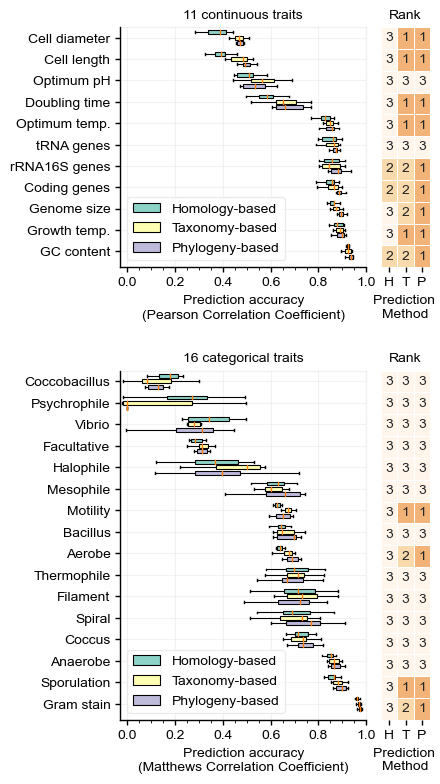

In [12]:
figure = plt.figure(figsize=(4, 9))
gs_master = GridSpec(nrows=2, ncols=2, height_ratios=[11, 16], width_ratios=[1, 0.2], hspace=0.35, wspace=0.1)

### Boxplot: continuous traits
gs_1 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0, 0])
axes_1 = figure.add_subplot(gs_1[:, :])

# Accuracy and Trait list of 10-fold cross validation
acc_list, trait_list = prep_accuracy_and_trait_list(res_all_melt=res_all_melt_nt)

# Plot
plot_accuracy_boxplot(acc_list=acc_list, trait_list=trait_list, ax=axes_1)
axes_1.set_title('11 continuous traits', fontsize=10)
axes_1.set_xlabel('Prediction accuracy\n(Pearson Correlation Coefficient)')

### Heatplot: continuous traits
gs_2 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0, 1])
axes_2 = figure.add_subplot(gs_2[:, :])

heatmap_df_nt = calc_rank(res_all_melt=res_all_melt_nt, trait_list=trait_list)

# Friedman test (all traits)
list_p_value_friedman = []
for i in np.arange(start=0, stop=len(acc_list), step=4):
    f_stat, p_value = friedmanchisquare(acc_list[i], acc_list[i+1], acc_list[i+2])
    list_p_value_friedman += [p_value]
res_mptest_friedman = multipletests(pvals=list_p_value_friedman, alpha=0.05, method="fdr_bh")

# Wilcoxon signed-rank test (positive traits)
list_p_value_wilcoxon = []
modified_trait_list = []
for i, t in enumerate(res_mptest_friedman[0]):
    if t:
        list_p_value_wilcoxon += [calc_wilcoxon_signed(res_all_melt_nt, trait_list[i])]
        modified_trait_list += [trait_list[i]]
res_mptest_wilcoxon = multipletests(pvals=[pv for p in list_p_value_wilcoxon for pv in p], alpha=0.05, method="fdr_bh")

i = 0
mp_pvals = []
for t in trait_list:
    if t in set(modified_trait_list):
        mp_pvals += [[res_mptest_wilcoxon[0][3*i+j] for j in [0, 1, 2]]]
        i += 1
    else:
        mp_pvals += [None]

for i, t in enumerate(trait_list):
    rank = list(heatmap_df_nt.loc[t, :])
    pvals = mp_pvals[i]
    if pvals is not None:
        heatmap_df_nt.loc[t, :] = stat_rank(rank, pvals)
    else:
        heatmap_df_nt.loc[t, :] = [3, 3, 3]

sns.heatmap(heatmap_df_nt, cmap=['#F2B379', '#F8DAAC', '#FFF5EB'],
            square=False, vmax=3, vmin=1, cbar=False, annot=True, xticklabels=1, yticklabels=1, linewidths=.5, ax=axes_2)
axes_2.set_xticklabels(['H', 'T', 'P'], rotation=0)
axes_2.set_xlabel('Prediction \nMethod')
axes_2.set_yticklabels([])
axes_2.set_title('Rank', fontsize=10)
axes_2.tick_params(left=False)

### Boxplot: categorical traits
gs_3 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[1, 0])
axes_3 = figure.add_subplot(gs_3[:, :])

acc_list, trait_list = prep_accuracy_and_trait_list(res_all_melt=res_all_melt_ct)
# Plot
plot_accuracy_boxplot(acc_list=acc_list, trait_list=trait_list, ax=axes_3)
axes_3.set_title('16 categorical traits', fontsize=10)
axes_3.set_xlabel('Prediction accuracy\n(Matthews Correlation Coefficient)')

### Heatmap: categorical traits
gs_4 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[1, 1])
axes_4 = figure.add_subplot(gs_4[:, :])

heatmap_df_ct = calc_rank(res_all_melt=res_all_melt_ct, trait_list=trait_list)

# Friedman test (all traits)
list_p_value_friedman = []
for i in np.arange(start=0, stop=len(acc_list), step=4):
    f_stat, p_value = friedmanchisquare(acc_list[i], acc_list[i+1], acc_list[i+2])
    list_p_value_friedman += [p_value]
res_mptest_friedman = multipletests(pvals=list_p_value_friedman, alpha=0.05, method="fdr_bh")

# Wilcoxon signed-rank test (positive traits)
list_p_value_wilcoxon = []
modified_trait_list = []
for i, t in enumerate(res_mptest_friedman[0]):
    if t:
        list_p_value_wilcoxon += [calc_wilcoxon_signed(res_all_melt_ct, trait_list[i])]
        modified_trait_list += [trait_list[i]]
res_mptest_wilcoxon = multipletests(pvals=[pv for p in list_p_value_wilcoxon for pv in p], alpha=0.05, method="fdr_bh")

i = 0
mp_pvals = []
for t in trait_list:
    if t in set(modified_trait_list):
        mp_pvals += [[res_mptest_wilcoxon[0][3*i+j] for j in [0, 1, 2]]]
        i += 1
    else:
        mp_pvals += [None]

for i, t in enumerate(trait_list):
    rank = list(heatmap_df_ct.loc[t, :])
    pvals = mp_pvals[i]
    if pvals is not None:
        heatmap_df_ct.loc[t, :] = stat_rank(rank, pvals)
    else:
        heatmap_df_ct.loc[t, :] = [3, 3, 3]

sns.heatmap(heatmap_df_ct, cmap=['#F2B379', '#F8DAAC', '#FFF5EB'],
            square=False, vmax=3, vmin=1, cbar=False, annot=True, xticklabels=1, yticklabels=1, linewidths=.5, ax=axes_4)

axes_4.set_xticklabels(['H', 'T', 'P'], rotation=0)
axes_4.set_xlabel('Prediction \nMethod')
axes_4.set_yticklabels([])
axes_4.set_title('Rank', fontsize=10)
axes_4.tick_params(left=False)

plt.savefig("../../results/03_cross_validation/fig2a-2b.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)